### Preparing the data

In [2]:
# check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0bf4b366-d003-a206-7974-815bbf93fb3d)
GPU 1: Tesla T4 (UUID: GPU-32fbf6b2-7467-6f0d-e940-64278eb66c1c)


In [3]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [4]:
# checking the version of tensorflow
print(tf.__version__)

2.6.4


In [5]:
# setting the random seeds for reproducibility of results
np.random.seed(7)
tf.random.set_seed(7)

import random
random.seed(7)

In [6]:
# data month by month
periods = pd.read_csv('/kaggle/input/consumer-price-index/cu.period.csv', index_col='period')

# contains type of indices and description
items = pd.read_csv('/kaggle/input/consumer-price-index/cu.item.csv')

# CPI values for food and beverages
fnb = pd.read_csv('/kaggle/input/consumer-price-index/cu.data.11.USFoodBeverage.csv')

In [7]:
fnb.drop('footnote_codes', axis=1, inplace=True)
fnb.series_id = [i[8:] for i in fnb.series_id]

In [8]:
items.head()

,item_code,item_name,display_level,selectable,sort_sequence
0,AA0,All items - old base,0.0,T,2.0
1,AA0R,Purchasing power of the consumer dollar - old ...,0.0,T,399.0
2,SA0,All items,0.0,T,1.0
3,SA0E,Energy,1.0,T,374.0
4,SA0L1,All items less food,1.0,T,358.0


In [9]:
fnb.head()

,series_id,year,period,value
0,SAF,1967,M01,34.8
1,SAF,1967,M02,34.7
2,SAF,1967,M03,34.7
3,SAF,1967,M04,34.6
4,SAF,1967,M05,34.6


In [10]:
c = np.array([[c, items.loc[items['item_code'] == c]['item_name'].values[0]] for c in fnb.series_id.unique()])
c = pd.DataFrame(c[:, 1], columns=['Stands for'], index=c[:,0])

In [11]:
c

,Stands for
SAF,Food and beverages
SAF1,Food
SAF11,Food at home
SAF111,Cereals and bakery products
SAF112,Meats
...,...
SS17032,Instant coffee
SS18042,Olives
SS18064,Prepared salads
SS20051,Beer


In [12]:
# merge year and period to use it as x on plots
fnb_m = fnb[fnb['period'].isin(periods.index[:12])].copy()
fnb_m.period = fnb_m.period.str.split('M').str[1]
fnb_m.year = fnb_m.year.astype(str)
fnb_m.year = fnb_m.year + '-' + fnb_m.period
fnb_m.drop('period', axis=1, inplace=True)
fnb_m.year = pd.to_datetime(fnb_m.year)

print(fnb_m.shape)
fnb_m.head()

(112710, 3)


,series_id,year,value
0,SAF,1967-01-01,34.8
1,SAF,1967-02-01,34.7
2,SAF,1967-03-01,34.7
3,SAF,1967-04-01,34.6
4,SAF,1967-05-01,34.6


# Considering the CPI values for Food

In [13]:
# Consider the values for food
df = fnb_m.loc[fnb_m['series_id'] == 'SAF1']
df = df.rename(columns={'year':'date'})
df.drop(['series_id'], axis=1, inplace=True)

# sort the values as they may not always be continuous
df.sort_values(by='date', inplace=True)

print(df.shape)
df.head()

(2098, 2)


,date,value
45664,1913-01-01,9.7
45665,1913-02-01,9.6
45666,1913-03-01,9.6
45667,1913-04-01,9.7
45668,1913-05-01,9.6


In [14]:
X = df['date']
y = df['value']

split_size = int(0.8 * len(X))

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1678, 420, 1678, 420)

In [15]:
# function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Date")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

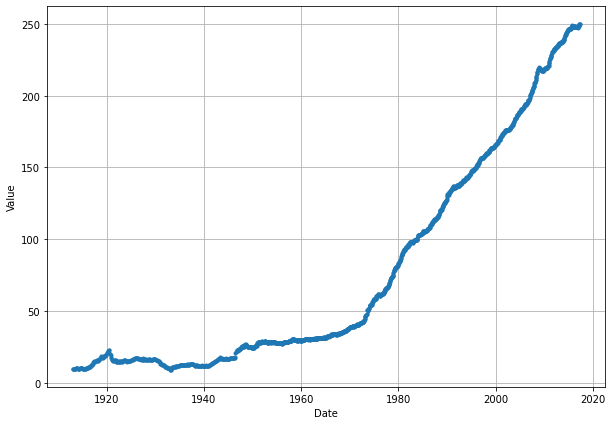

In [16]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=df['date'], values=df['value'])

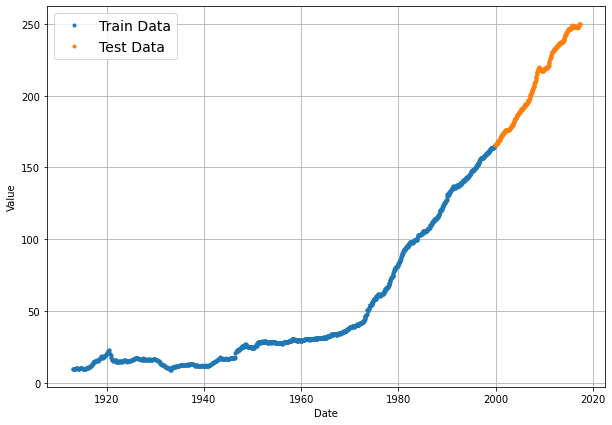

In [17]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train Data')
plot_time_series(timesteps=X_test, values=y_test, label='Test Data')

In [18]:
X_train.max()

Timestamp('1999-11-01 00:00:00')

### Windowing the data

In [19]:
# function for getting the labelled windows
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

WINDOW = 8
HORIZON = 1

In [20]:
values = df['value'].to_numpy();

In [21]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2090, 2090)

In [22]:
for i in range(5):
  print(f"Window: {windows[i]} -> Label: {labels[i]}")

Window: [ 9.7  9.6  9.6  9.7  9.6  9.7  9.9 10. ] -> Label: [10.2]
Window: [ 9.6  9.6  9.7  9.6  9.7  9.9 10.  10.2] -> Label: [10.3]
Window: [ 9.6  9.7  9.6  9.7  9.9 10.  10.2 10.3] -> Label: [10.4]
Window: [ 9.7  9.6  9.7  9.9 10.  10.2 10.3 10.4] -> Label: [10.3]
Window: [ 9.6  9.7  9.9 10.  10.2 10.3 10.4 10.3] -> Label: [10.3]


### Train Test Splitting the Windows

In [23]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [24]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1672, 418, 1672, 418)

### Function for evaluating the models

In [25]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae/mae_naive_no_season

# function for evaluating timeseries prediction
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
    'mae': mae.numpy(),
    'mse': mse.numpy(),
    'rmse': rmse.numpy(),
    'mape': mape.numpy(),
    'mase': mase.numpy()
  }

### Function for making forecasts with a model

In [26]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

### Creating a modelling checkpoint for saving the best model

In [27]:
import os

def create_model_checkpoint(model_name, save_path="model_checkpoints"):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_path, model_name),
    verbose=0,
    save_best_only=True
  )

# Create a function for making dense models with given window and horizon sizes

In [27]:
# function that creates and compiles a dense model with the given window and horizon sizes
def make_dense_model(window_size=7, horizon_size=1, model_name='dense'):
  # setting random seed for reproducible results
  tf.random.set_seed(7)
  np.random.seed(7)

  # create the model
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(horizon_size, activation='linear')
  ], name=model_name)

  # compile the model
  model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae']
  )
  
  # return the model
  return model


## Dense Model (window=8, horizon=1)

In [100]:
WINDOW = 8
HORIZON = 1

In [101]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)

In [30]:
# make the model
dense_window_8_horizon_1 = make_dense_model(window_size=8, horizon_size=1, model_name='dense_window_8_horizon_1')

# fit the model
dense_window_8_horizon_1_history = dense_window_8_horizon_1.fit(
  x=train_windows,
  y=train_labels,
  epochs=100,
  verbose=1,
  batch_size=128,
  validation_data=(test_windows,test_labels),
  callbacks=[create_model_checkpoint(model_name=dense_window_8_horizon_1.name)]
)

2022-11-26 14:12:42.718114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 14:12:42.719110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 14:12:43.060270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 14:12:43.061234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 14:12:43.062097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/100
14/14 [==============================] - 3s 19ms/step - loss: 61.9647 - mae: 61.9647 - val_loss: 103.0570 - val_mae: 103.0570


2022-11-26 14:12:51.062604: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 11.5988 - mae: 11.5988 - val_loss: 36.4878 - val_mae: 36.4878
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 5.1280 - mae: 5.1280 - val_loss: 11.4036 - val_mae: 11.4036
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 2.1555 - mae: 2.1555 - val_loss: 9.2778 - val_mae: 9.2778
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 1.4067 - mae: 1.4067 - val_loss: 0.7257 - val_mae: 0.7257
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6666 - mae: 0.6666 - val_loss: 1.8122 - val_mae: 1.8122
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5467 - mae: 0.5467 - val_loss: 0.6472 - val_mae: 0.6472
Epoch 8/100
14/14 [==============================] - 0s 4ms/step - loss: 0.4685 - mae: 0.4685 - val_loss: 0.6350 - val_mae: 0.6350
Epoch 9/100
14/14 [==============================] - 0s 4ms/step - loss: 0.47

In [102]:
# load the best performing model from the model checkpoint
dense_window_8_horizon_1 = tf.keras.models.load_model("model_checkpoints/dense_window_8_horizon_1")
dense_window_8_horizon_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.5049 - mae: 0.5049


[0.5049470067024231, 0.5049470067024231]

In [103]:
dense_window_8_horizon_1_preds = make_preds(dense_window_8_horizon_1, test_windows)
len(dense_window_8_horizon_1_preds), dense_window_8_horizon_1_preds[:10]

(418,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([165.65662, 165.7318 , 165.9819 , 166.11836, 166.3125 , 166.53201,
        166.62839, 166.74612, 166.87683, 167.10002], dtype=float32)>)

In [104]:
# make predictions using model_1
dense_window_8_horizon_1_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred=dense_window_8_horizon_1_preds
)

dense_window_8_horizon_1_results

{'mae': 0.504947,
 'mse': 0.44705787,
 'rmse': 0.66862386,
 'mape': 0.23896529,
 'mase': 625.76636}

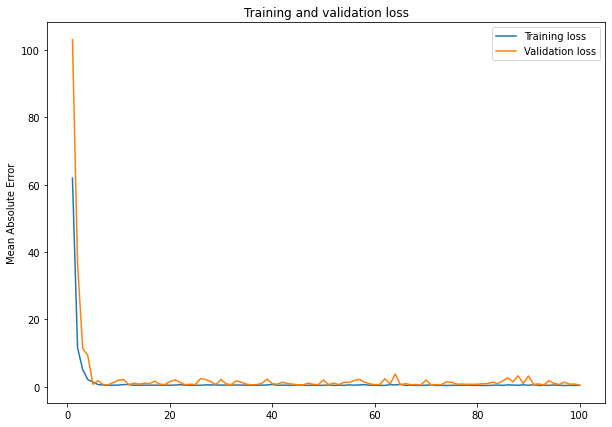

In [34]:
# visualize the loss
loss = dense_window_8_horizon_1_history.history['loss']
val_loss = dense_window_8_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

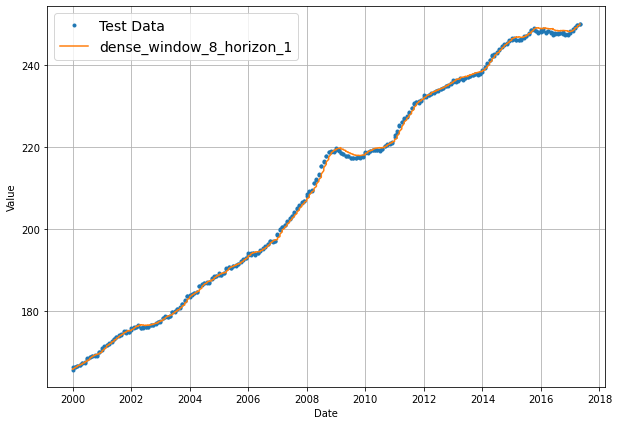

In [35]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=dense_window_8_horizon_1_preds, format='-', label='dense_window_8_horizon_1')

## Dense Model (window=15, horizon=1)

In [105]:
WINDOW = 15
HORIZON = 1

In [106]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2083, 2083)

In [107]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1666, 417, 1666, 417)

In [39]:
# make the model
dense_window_15_horizon_1 = make_dense_model(window_size=WINDOW, horizon_size=HORIZON, model_name='dense_window_15_horizon_1')

# fit the model
dense_window_15_horizon_1_history = dense_window_15_horizon_1.fit(
  x=train_windows,
  y=train_labels,
  epochs=100,
  verbose=1,
  batch_size=128,
  validation_data=(test_windows,test_labels),
  callbacks=[create_model_checkpoint(model_name=dense_window_15_horizon_1.name)]
)

Epoch 1/100
14/14 [==============================] - 1s 15ms/step - loss: 34.0781 - mae: 34.0781 - val_loss: 31.2957 - val_mae: 31.2957
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 6.5183 - mae: 6.5183 - val_loss: 12.2858 - val_mae: 12.2858
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 1.7933 - mae: 1.7933 - val_loss: 3.5969 - val_mae: 3.5969
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.9905 - mae: 0.9905 - val_loss: 1.0554 - val_mae: 1.0554
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6831 - mae: 0.6831 - val_loss: 1.5732 - val_mae: 1.5732
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6327 - mae: 0.6327 - val_loss: 2.8564 - val_mae: 2.8564
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.7371 - mae: 0.7371 - val_loss: 1.1334 - val_mae: 1.1334
Epoch 8/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6

In [108]:
# load the best performing model from the model checkpoint
dense_window_15_horizon_1 = tf.keras.models.load_model("model_checkpoints/dense_window_15_horizon_1")
dense_window_15_horizon_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.4914 - mae: 0.4914


[0.49137353897094727, 0.49137353897094727]

In [109]:
dense_window_15_horizon_1_preds = make_preds(dense_window_15_horizon_1, test_windows)
len(dense_window_15_horizon_1_preds),dense_window_15_horizon_1_preds[:10]

(417,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([165.74501, 165.91052, 166.1849 , 166.32758, 166.49911, 166.63324,
        166.71785, 166.83597, 167.05309, 167.2742 ], dtype=float32)>)

In [110]:
dense_window_15_horizon_1_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=dense_window_15_horizon_1_preds
)

dense_window_15_horizon_1_results

{'mae': 0.49137354,
 'mse': 0.42191064,
 'rmse': 0.6495465,
 'mape': 0.23266552,
 'mase': 626.82}

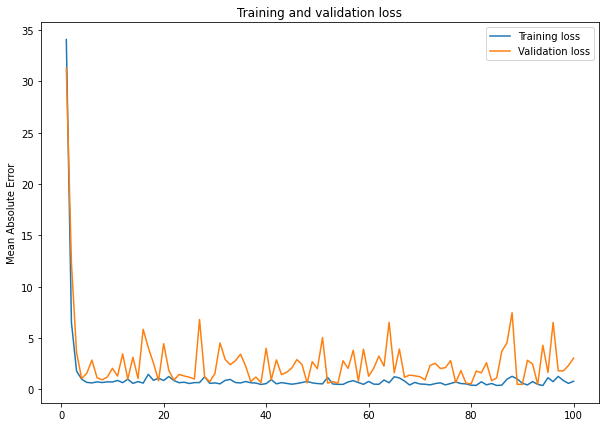

In [43]:
# visualize the loss
loss = dense_window_15_horizon_1_history.history['loss']
val_loss = dense_window_15_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

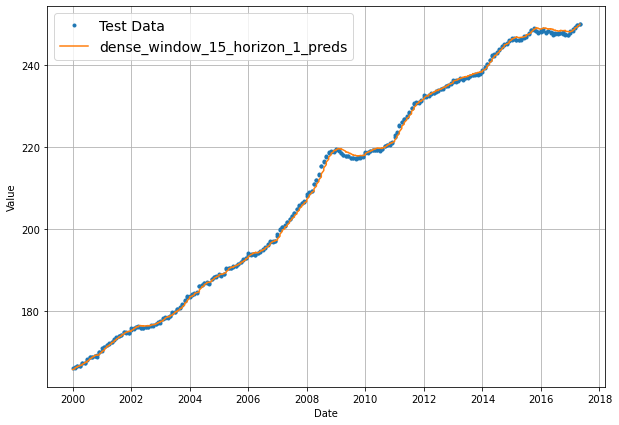

In [44]:
#visualizing the predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=dense_window_15_horizon_1_preds, format='-', label='dense_window_15_horizon_1_preds')

## Dense Model (window=8, horizon=3)

In [111]:
WINDOW = 8
HORIZON = 3

In [112]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)

In [47]:
# make the model
dense_window_8_horizon_3 = make_dense_model(window_size=WINDOW, horizon_size=HORIZON, model_name='dense_window_8_horizon_3')

# fit the model
dense_window_8_horizon_3_history = dense_window_8_horizon_3.fit(
  x=train_windows,
  y=train_labels,
  epochs=100,
  verbose=1,
  batch_size=128,
  validation_data=(test_windows,test_labels),
  callbacks=[create_model_checkpoint(model_name=dense_window_8_horizon_3.name)]
)

Epoch 1/100
14/14 [==============================] - 0s 11ms/step - loss: 43.8727 - mae: 43.8727 - val_loss: 68.9893 - val_mae: 68.9893
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 8.7229 - mae: 8.7229 - val_loss: 20.2765 - val_mae: 20.2765
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 3.3795 - mae: 3.3795 - val_loss: 5.4081 - val_mae: 5.4081
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 1.3629 - mae: 1.3629 - val_loss: 3.3132 - val_mae: 3.3132
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.7718 - mae: 0.7718 - val_loss: 1.1896 - val_mae: 1.1896
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5599 - mae: 0.5599 - val_loss: 0.8502 - val_mae: 0.8502
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5328 - mae: 0.5328 - val_loss: 1.1240 - val_mae: 1.1240
Epoch 8/100
14/14 [==============================] - 0s 5ms/step - loss: 0.5

In [113]:
# load the best performing model from the model checkpoint
dense_window_8_horizon_3 = tf.keras.models.load_model("model_checkpoints/dense_window_8_horizon_3")
dense_window_8_horizon_3.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.6946 - mae: 0.6946


[0.6946203708648682, 0.6946203708648682]

In [114]:
dense_window_8_horizon_3_preds = make_preds(dense_window_8_horizon_3, test_windows)
len(dense_window_8_horizon_3_preds), dense_window_8_horizon_3_preds[:10]

(418,
 <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
 array([[165.66989, 165.50584, 165.28369],
        [165.93483, 165.68462, 165.46457],
        [165.99562, 165.73221, 165.54222],
        [166.25438, 165.93835, 165.71423],
        [166.32188, 166.07408, 165.85233],
        [166.58226, 166.35294, 166.07413],
        [166.63478, 166.502  , 166.24936],
        [166.80115, 166.65985, 166.40213],
        [166.96451, 166.79524, 166.55551],
        [167.11052, 166.87033, 166.67949]], dtype=float32)>)

In [115]:
# make predictions using model_1
dense_window_8_horizon_3_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred=dense_window_8_horizon_3_preds
)

dense_window_8_horizon_3_results

{'mae': 0.69462043,
 'mse': 0.83081144,
 'rmse': 0.78396547,
 'mape': 0.32884282,
 'mase': 625.73566}

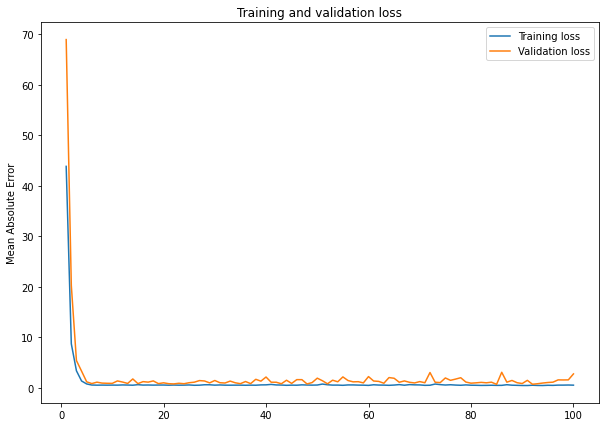

In [51]:
# visualize the loss
loss = dense_window_8_horizon_3_history.history['loss']
val_loss = dense_window_8_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

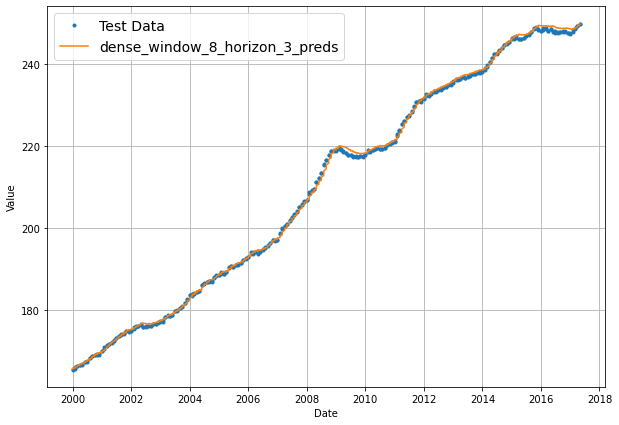

In [52]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(dense_window_8_horizon_3_preds, axis=1), format='-', label='dense_window_8_horizon_3_preds')

## Dense Model (window=15, horizon=3)

In [116]:
WINDOW = 15
HORIZON = 3

In [117]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)

In [55]:
# make the model
dense_window_15_horizon_3 = make_dense_model(window_size=WINDOW, horizon_size=HORIZON, model_name='dense_window_15_horizon_3')

# fit the model
dense_window_15_horizon_3_history = dense_window_15_horizon_3.fit(
  x=train_windows,
  y=train_labels,
  epochs=100,
  verbose=1,
  batch_size=128,
  validation_data=(test_windows,test_labels),
  callbacks=[create_model_checkpoint(model_name=dense_window_15_horizon_3.name)]
)

Epoch 1/100
13/13 [==============================] - 0s 12ms/step - loss: 22.4829 - mae: 22.4829 - val_loss: 13.5392 - val_mae: 13.5392
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 5.0171 - mae: 5.0171 - val_loss: 7.1948 - val_mae: 7.1948
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 2.3396 - mae: 2.3396 - val_loss: 5.4493 - val_mae: 5.4493
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 1.2360 - mae: 1.2360 - val_loss: 1.0523 - val_mae: 1.0523
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.8904 - mae: 0.8904 - val_loss: 1.4669 - val_mae: 1.4669
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.7449 - mae: 0.7449 - val_loss: 1.0861 - val_mae: 1.0861
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6982 - mae: 0.6982 - val_loss: 1.1900 - val_mae: 1.1900
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.701

In [118]:
# load the best performing model from the model checkpoint
dense_window_15_horizon_3 = tf.keras.models.load_model("model_checkpoints/dense_window_15_horizon_3")
dense_window_15_horizon_3.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.6721 - mae: 0.6721


[0.6720970273017883, 0.6720970273017883]

In [119]:
dense_window_15_horizon_3_preds = make_preds(dense_window_15_horizon_3, test_windows)
len(dense_window_15_horizon_3_preds), dense_window_15_horizon_3_preds[:10]

(417,
 <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
 array([[165.15558, 165.65723, 165.48485],
        [165.26126, 165.81331, 165.68448],
        [165.4643 , 166.03546, 165.83601],
        [165.55728, 166.26025, 166.05238],
        [165.79361, 166.5153 , 166.26228],
        [165.93463, 166.69446, 166.32033],
        [166.07507, 166.81506, 166.53577],
        [166.33908, 166.95662, 166.64236],
        [166.40512, 166.94687, 166.78334],
        [166.62814, 167.15991, 166.92229]], dtype=float32)>)

In [120]:
# make predictions using model_1
dense_window_15_horizon_3_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred=dense_window_15_horizon_3_preds
)

dense_window_15_horizon_3_results

{'mae': 0.67209697,
 'mse': 0.771588,
 'rmse': 0.7376085,
 'mape': 0.32092416,
 'mase': 625.5954}

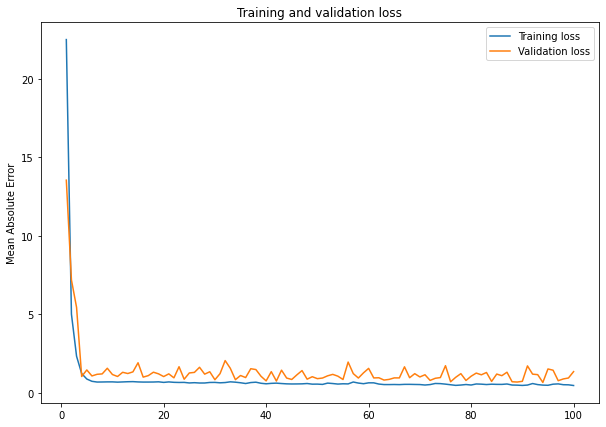

In [59]:
# visualize the loss
loss = dense_window_15_horizon_3_history.history['loss']
val_loss = dense_window_15_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

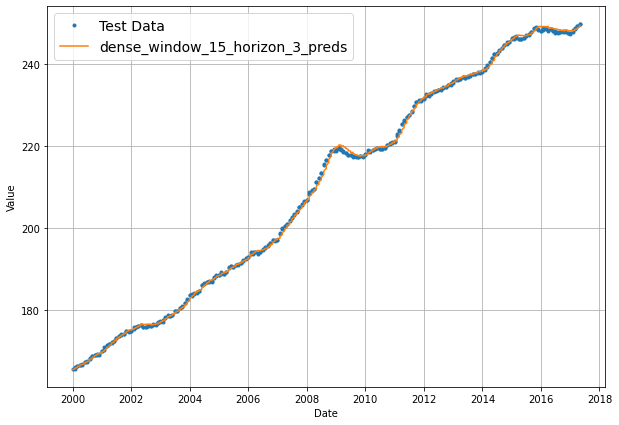

In [60]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(dense_window_15_horizon_3_preds, axis=1), format='-', label='dense_window_15_horizon_3_preds')

<AxesSubplot:>

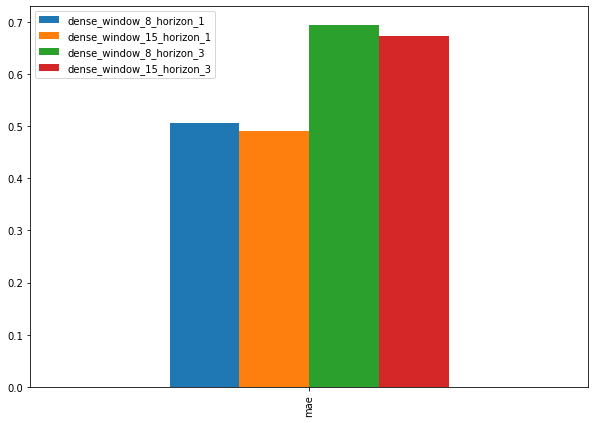

In [121]:
pd.DataFrame({
    'dense_window_8_horizon_1': dense_window_8_horizon_1_results['mae'],
    'dense_window_15_horizon_1': dense_window_15_horizon_1_results['mae'],
    'dense_window_8_horizon_3': dense_window_8_horizon_3_results['mae'],
    'dense_window_15_horizon_3': dense_window_15_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

## function for creating LSTM with given window size and horizon size

In [30]:
def make_lstm_model(window_size=8, horizon_size=1, model_name='lstm'):
  tf.random.set_seed(7)
  np.random.seed(7)

  inputs = tf.keras.layers.Input(shape=(window_size))
  x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)

  x = tf.keras.layers.LSTM(128, activation="relu")(x)

  output = tf.keras.layers.Dense(horizon_size)(x)

  model = tf.keras.Model(inputs=inputs, outputs=output, name=model_name)

  model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam()
  )

  return model


## LSTM (window=8, horizon=1)

In [122]:
WINDOW = 8
HORIZON = 1

In [123]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2090, 2090)

In [124]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1672, 418, 1672, 418)

In [65]:
lstm_window_8_horizon_1 = make_lstm_model(window_size=WINDOW, horizon_size=HORIZON, model_name='lstm_window_8_horizon_1')

lstm_window_8_horizon_1_history = lstm_window_8_horizon_1.fit(
  train_windows,
  train_labels,
  epochs=100,
  verbose=0,
  batch_size=128,
  validation_data=(test_windows, test_labels),
  callbacks=[create_model_checkpoint(model_name=lstm_window_8_horizon_1.name)]
)

In [125]:
lstm_window_8_horizon_1 = tf.keras.models.load_model("model_checkpoints/lstm_window_8_horizon_1")
lstm_window_8_horizon_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.6083


0.6082509160041809

In [126]:
lstm_window_8_horizon_1_preds = make_preds(lstm_window_8_horizon_1, test_windows)
lstm_window_8_horizon_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([166.12639, 166.243  , 166.38103, 166.53816, 166.70052, 166.895  ,
       167.03406, 167.20552, 167.37268, 167.49037], dtype=float32)>

In [127]:
lstm_window_8_horizon_1_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=lstm_window_8_horizon_1_preds
)

lstm_window_8_horizon_1_results

{'mae': 0.6082509,
 'mse': 0.6321973,
 'rmse': 0.7951084,
 'mape': 0.28541556,
 'mase': 625.76636}

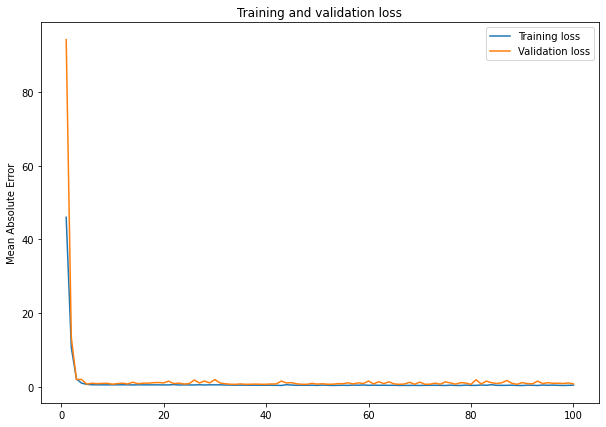

In [70]:
# visualize the loss
loss = lstm_window_8_horizon_1_history.history['loss']
val_loss = lstm_window_8_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

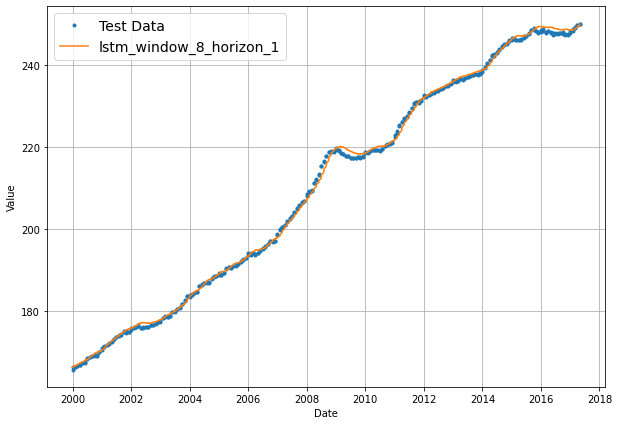

In [73]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=lstm_window_8_horizon_1_preds, format='-', label='lstm_window_8_horizon_1')

## LSTM (window=15, horizon=1)

In [128]:
WINDOW = 15
HORIZON = 1

In [129]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2083, 2083)

In [130]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1666, 417, 1666, 417)

In [37]:
lstm_window_15_horizon_1 = make_lstm_model(window_size=WINDOW, horizon_size=HORIZON, model_name='lstm_window_15_horizon_1')

lstm_window_15_horizon_1_history = lstm_window_15_horizon_1.fit(
  train_windows,
  train_labels,
  epochs=100,
  verbose=0,
  batch_size=128,
  validation_data=(test_windows, test_labels),
  callbacks=[create_model_checkpoint(model_name=lstm_window_15_horizon_1.name)]
)

2022-11-26 17:09:26.629602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-26 17:09:30.391830: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [131]:
lstm_window_15_horizon_1 = tf.keras.models.load_model("model_checkpoints/lstm_window_15_horizon_1")
lstm_window_15_horizon_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.8285


0.8285304307937622

In [132]:
lstm_window_15_horizon_1_preds = make_preds(lstm_window_15_horizon_1, test_windows)
lstm_window_15_horizon_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([165.85818, 166.04875, 166.18849, 166.39575, 166.55003, 166.71664,
       166.86174, 167.00017, 167.16806, 167.31543], dtype=float32)>

In [133]:
lstm_window_15_horizon_1_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=lstm_window_15_horizon_1_preds
)

lstm_window_15_horizon_1_results

{'mae': 0.82853043,
 'mse': 1.206178,
 'rmse': 1.0982614,
 'mape': 0.38638258,
 'mase': 626.82}

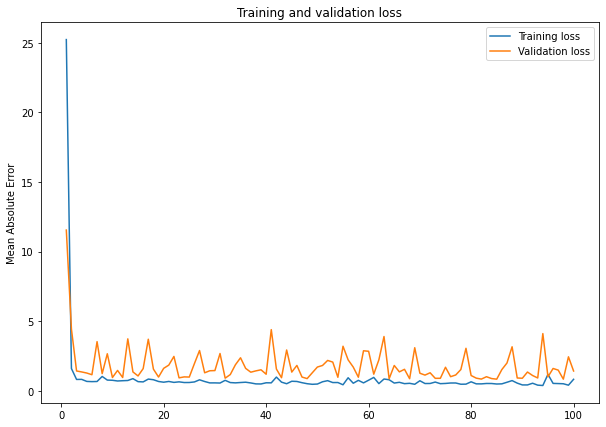

In [41]:
# visualize the loss
loss = lstm_window_15_horizon_1_history.history['loss']
val_loss = lstm_window_15_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

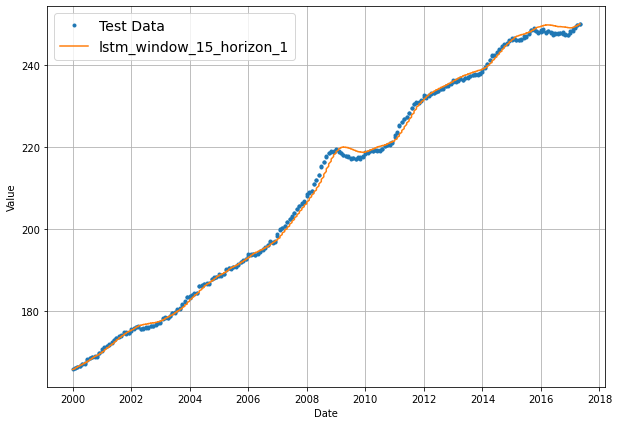

In [42]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=lstm_window_15_horizon_1_preds, format='-', label='lstm_window_15_horizon_1')

## LSTM (window=8, horizon=3)

In [134]:
WINDOW = 8
HORIZON = 3

In [135]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2088, 2088)

In [136]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1670, 418, 1670, 418)

In [46]:
lstm_window_8_horizon_3 = make_lstm_model(window_size=WINDOW, horizon_size=HORIZON, model_name='lstm_window_8_horizon_3')

lstm_window_8_horizon_3_history = lstm_window_8_horizon_3.fit(
  train_windows,
  train_labels,
  epochs=100,
  verbose=0,
  batch_size=128,
  validation_data=(test_windows, test_labels),
  callbacks=[create_model_checkpoint(model_name=lstm_window_8_horizon_3.name)]
)

In [137]:
lstm_window_8_horizon_3 = tf.keras.models.load_model("model_checkpoints/lstm_window_8_horizon_3")
lstm_window_8_horizon_3.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.7507


0.7506672143936157

In [138]:
lstm_window_8_horizon_3_preds = make_preds(lstm_window_8_horizon_3, test_windows)
lstm_window_8_horizon_3_preds[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[165.63367, 165.91005, 165.90894],
       [165.78328, 166.0801 , 166.04706],
       [165.96448, 166.21713, 166.20848],
       [166.09044, 166.3613 , 166.32465],
       [166.28073, 166.53981, 166.48828],
       [166.40102, 166.69241, 166.61896],
       [166.56264, 166.853  , 166.80118],
       [166.70384, 167.00848, 166.98276],
       [166.86691, 167.15945, 167.13101],
       [167.02856, 167.31007, 167.29288]], dtype=float32)>

In [139]:
lstm_window_8_horizon_3_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=lstm_window_8_horizon_3_preds
)

lstm_window_8_horizon_3_results

{'mae': 0.75066715,
 'mse': 0.97011334,
 'rmse': 0.7892579,
 'mape': 0.34886023,
 'mase': 625.73566}

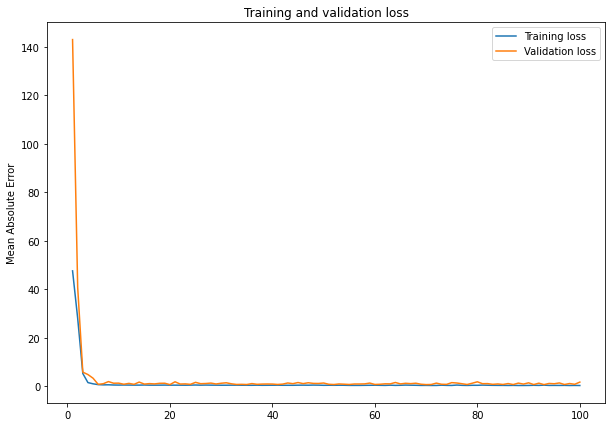

In [55]:
# visualize the loss
loss = lstm_window_8_horizon_3_history.history['loss']
val_loss = lstm_window_8_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

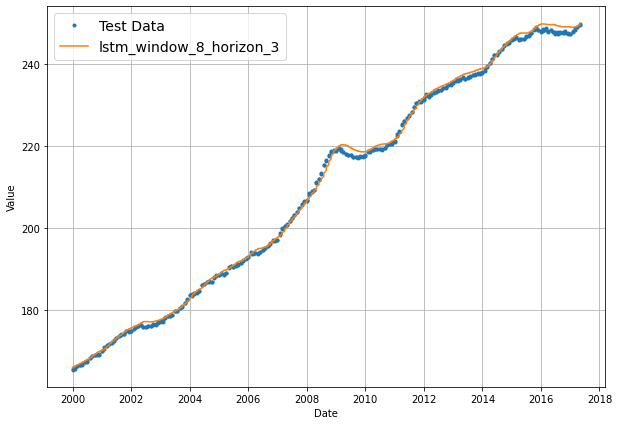

In [57]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(lstm_window_8_horizon_3_preds, axis=1), format='-', label='lstm_window_8_horizon_3')

## LSTM (window=15, horizon=3)

In [140]:
WINDOW = 15
HORIZON = 3

In [141]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2081, 2081)

In [142]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1664, 417, 1664, 417)

In [61]:
lstm_window_15_horizon_3 = make_lstm_model(window_size=WINDOW, horizon_size=HORIZON, model_name='lstm_window_15_horizon_3')

lstm_window_15_horizon_3_history = lstm_window_15_horizon_3.fit(
  train_windows,
  train_labels,
  epochs=100,
  verbose=0,
  batch_size=128,
  validation_data=(test_windows, test_labels),
  callbacks=[create_model_checkpoint(model_name=lstm_window_15_horizon_3.name)]
)

In [143]:
lstm_window_15_horizon_3 = tf.keras.models.load_model("model_checkpoints/lstm_window_15_horizon_3")
lstm_window_15_horizon_3.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.8870


0.8870406746864319

In [144]:
lstm_window_15_horizon_3_preds = make_preds(lstm_window_15_horizon_3, test_windows)
lstm_window_15_horizon_3_preds[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[165.90294, 165.96986, 166.31415],
       [166.10136, 166.16214, 166.46529],
       [166.15358, 166.25897, 166.63414],
       [166.39615, 166.48143, 166.7723 ],
       [166.50961, 166.57887, 166.98633],
       [166.73549, 166.82884, 167.15811],
       [166.843  , 166.91292, 167.30608],
       [167.04135, 167.13171, 167.45697],
       [167.12355, 167.21538, 167.53323],
       [167.32512, 167.41908, 167.73358]], dtype=float32)>

In [145]:
lstm_window_15_horizon_3_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=lstm_window_15_horizon_3_preds
)

lstm_window_15_horizon_3_results

{'mae': 0.8870407,
 'mse': 1.42041,
 'rmse': 0.9283749,
 'mape': 0.41221476,
 'mase': 625.5954}

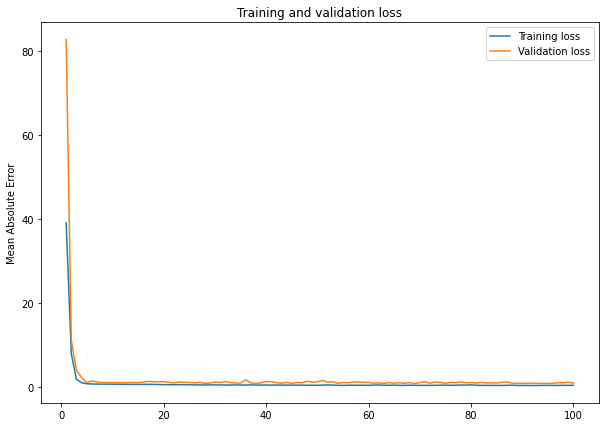

In [65]:
# visualize the loss
loss = lstm_window_15_horizon_3_history.history['loss']
val_loss = lstm_window_15_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

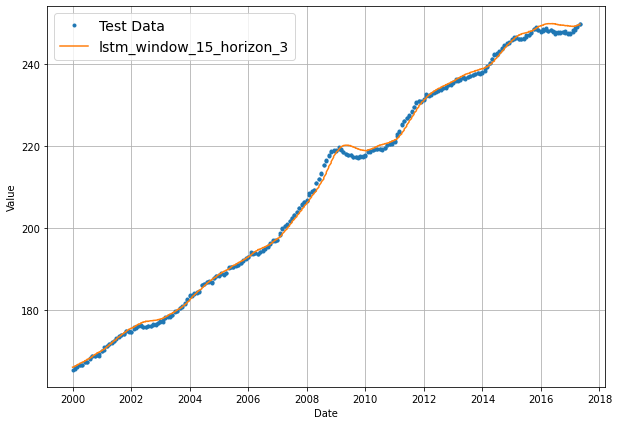

In [93]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(lstm_window_15_horizon_3_preds, axis=1), format='-', label='lstm_window_15_horizon_3')

<AxesSubplot:>

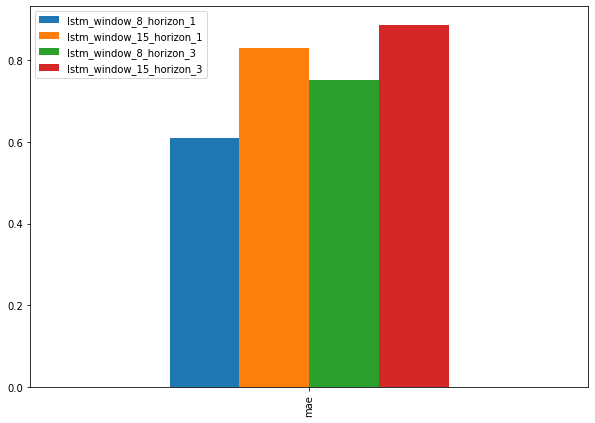

In [146]:
pd.DataFrame({
    'lstm_window_8_horizon_1': lstm_window_8_horizon_1_results['mae'],
    'lstm_window_15_horizon_1': lstm_window_15_horizon_1_results['mae'],
    'lstm_window_8_horizon_3': lstm_window_8_horizon_3_results['mae'],
    'lstm_window_15_horizon_3': lstm_window_15_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

# function for creating N-BEATS model with given window and horizon size

In [28]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [29]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

In [59]:
def make_nbeats_model(window_size=8, horizon_size=1, model_name='nbeats'):
    WINDOW = window_size
    HORIZON = horizon_size

    INPUT_SIZE = WINDOW # called "Lookback" in Table 18
    THETA_SIZE = INPUT_SIZE + HORIZON

    tf.random.set_seed(7)
    np.random.seed(7)

    nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                     theta_size=THETA_SIZE,
                                     horizon=HORIZON,
                                     n_neurons=N_NEURONS,
                                     n_layers=N_LAYERS,
                                     name="InitialBlock")

    stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")


    backcast, forecast = nbeats_block_layer(stack_input)

    residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00") 

    # 4. Create stacks of blocks
    for i, _ in enumerate(range(N_STACKS-1)):

      backcast, block_forecast = NBeatsBlock(
          input_size=INPUT_SIZE,
          theta_size=THETA_SIZE,
          horizon=HORIZON,
          n_neurons=N_NEURONS,
          n_layers=N_LAYERS,
          name=f"NBeatsBlock_{i}"
      )(residuals)

      residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
      forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

    model = tf.keras.Model(inputs=stack_input, 
                             outputs=forecast, 
                             name=model_name)

    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=["mae", "mse"])
    
    return model


## N-Beats (window=8, horizon=1)

In [79]:
WINDOW = 8
HORIZON = 1

In [80]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2090, 2090)

In [81]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1672, 418, 1672, 418)

In [82]:
nbeats_window_8_horizon_1 = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_8_horizon_1')

nbeats_window_8_horizon_1_history = nbeats_window_8_horizon_1.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00133: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00354: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00454: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [83]:
nbeats_window_8_horizon_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 10ms/step - loss: 0.2987 - mae: 0.2987 - mse: 0.1719


[0.29873672127723694, 0.29873672127723694, 0.1719488501548767]

In [84]:
nbeats_window_8_horizon_1_preds = make_preds(nbeats_window_8_horizon_1, test_windows)
nbeats_window_8_horizon_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([165.70328, 165.81474, 166.08083, 166.43307, 166.55151],
      dtype=float32)>

In [85]:
nbeats_window_8_horizon_1_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred = nbeats_window_8_horizon_1_preds
)

nbeats_window_8_horizon_1_results

{'mae': 0.29873672,
 'mse': 0.17194885,
 'rmse': 0.41466716,
 'mape': 0.142523,
 'mase': 625.76636}

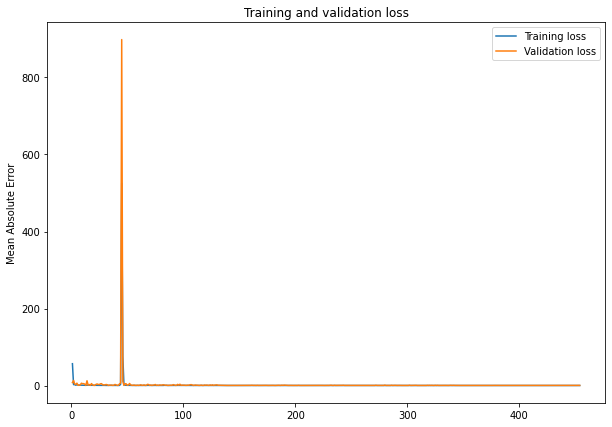

In [86]:
# visualize the loss
loss = nbeats_window_8_horizon_1_history.history['loss']
val_loss = nbeats_window_8_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

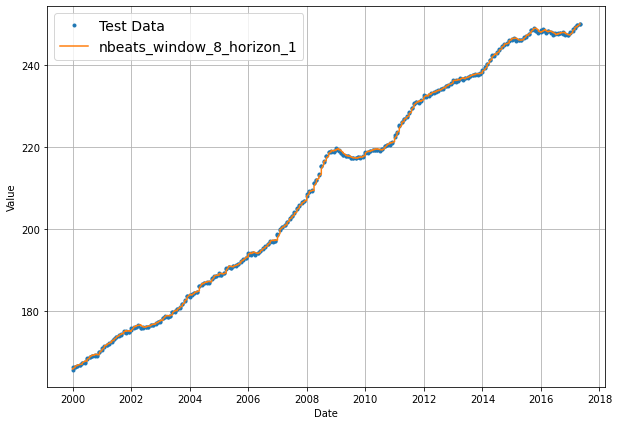

In [87]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=nbeats_window_8_horizon_1_preds, format='-', label='nbeats_window_8_horizon_1')

## N-Beats (window=15, horizon=1)

In [39]:
WINDOW = 15
HORIZON = 1

In [40]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2083, 2083)

In [41]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1666, 417, 1666, 417)

In [38]:
nbeats_window_15_horizon_1 = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_15_horizon_1')

nbeats_window_15_horizon_1_history = nbeats_window_15_horizon_1.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00464: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00564: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [42]:
nbeats_window_15_horizon_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 10ms/step - loss: 0.2931 - mae: 0.2931 - mse: 0.1643


[0.2931176424026489, 0.2931176424026489, 0.164255291223526]

In [43]:
nbeats_window_15_horizon_1_preds = make_preds(nbeats_window_15_horizon_1, test_windows)
nbeats_window_15_horizon_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([165.80049, 166.1612 , 166.39635, 166.4876 , 166.6757 ],
      dtype=float32)>

In [44]:
nbeats_window_15_horizon_1_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred = nbeats_window_15_horizon_1_preds
)

nbeats_window_15_horizon_1_results

{'mae': 0.29311764,
 'mse': 0.16425526,
 'rmse': 0.40528417,
 'mape': 0.13953039,
 'mase': 626.82}

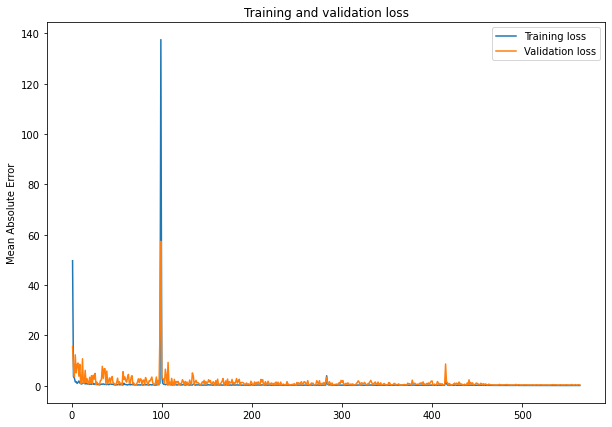

In [45]:
# visualize the loss
loss = nbeats_window_15_horizon_1_history.history['loss']
val_loss = nbeats_window_15_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

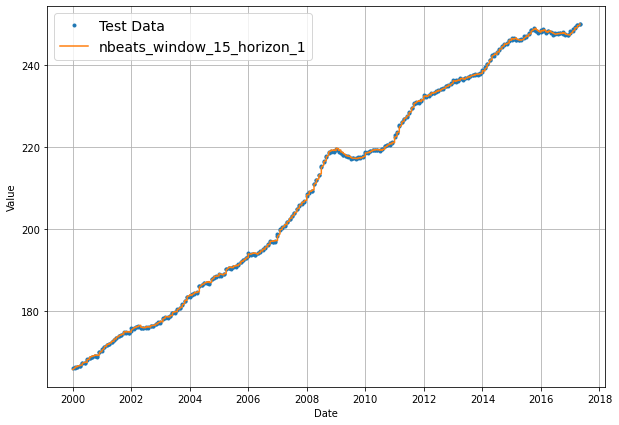

In [46]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=nbeats_window_15_horizon_1_preds, format='-', label='nbeats_window_15_horizon_1')

## N-Beats (window=8, horizon=3)

In [60]:
WINDOW = 8
HORIZON = 3

In [61]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2088, 2088)

In [62]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1670, 418, 1670, 418)

In [63]:
nbeats_window_8_horizon_3 = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_8_horizon_3')

nbeats_window_8_horizon_3_history = nbeats_window_8_horizon_3.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00270: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00398: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00498: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [64]:
nbeats_window_8_horizon_3.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 9ms/step - loss: 0.4105 - mae: 0.4105 - mse: 0.3235


[0.410453736782074, 0.410453736782074, 0.3235451877117157]

In [65]:
nbeats_window_8_horizon_3_preds = make_preds(nbeats_window_8_horizon_3, test_windows)
nbeats_window_8_horizon_3_preds[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[165.48953, 165.58517, 165.84401],
       [165.5678 , 165.75717, 165.94739],
       [165.71602, 165.85352, 166.09824],
       [165.8015 , 165.96945, 166.17723],
       [166.14233, 166.36993, 166.59726]], dtype=float32)>

In [66]:
nbeats_window_8_horizon_3_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred = nbeats_window_8_horizon_3_preds
)

nbeats_window_8_horizon_3_results

{'mae': 0.4104538,
 'mse': 0.3235452,
 'rmse': 0.45337278,
 'mape': 0.19474337,
 'mase': 625.73566}

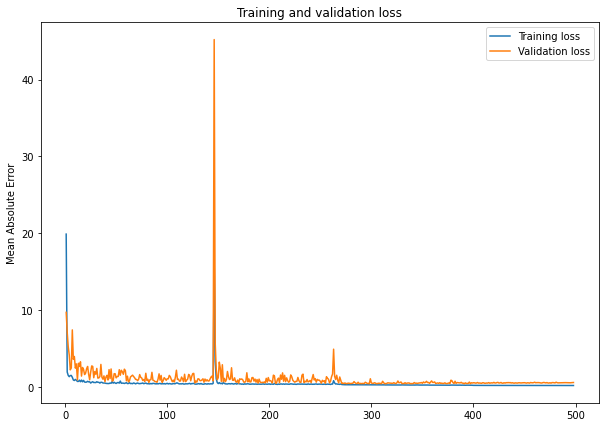

In [67]:
# visualize the loss
loss = nbeats_window_8_horizon_3_history.history['loss']
val_loss = nbeats_window_8_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

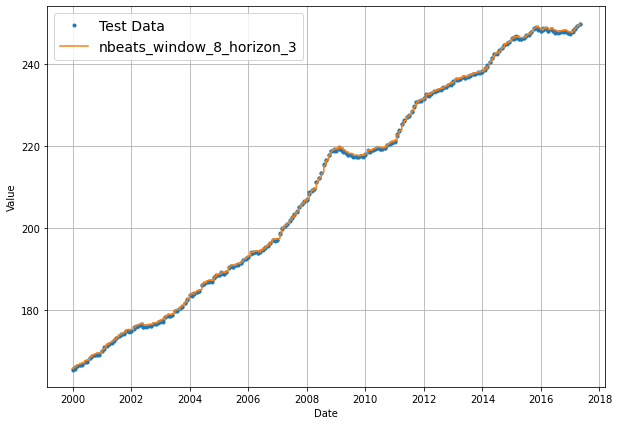

In [68]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(nbeats_window_8_horizon_3_preds, axis=1), format='-', label='nbeats_window_8_horizon_3')

## N-Beats (window=15, horizon=3)

In [69]:
WINDOW = 15
HORIZON = 3

In [70]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(2081, 2081)

In [71]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1664, 417, 1664, 417)

In [72]:
nbeats_window_15_horizon_3 = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_15_horizon_3')

nbeats_window_15_horizon_3_history = nbeats_window_15_horizon_3.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00239: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00339: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [73]:
nbeats_window_15_horizon_3.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 9ms/step - loss: 0.4012 - mae: 0.4012 - mse: 0.2760


[0.4011673331260681, 0.4011673331260681, 0.275976300239563]

In [74]:
nbeats_window_15_horizon_3_preds = make_preds(nbeats_window_15_horizon_3, test_windows)
nbeats_window_15_horizon_3_preds[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[165.57776, 165.90054, 166.17708],
       [165.74237, 166.01169, 166.34311],
       [165.82169, 166.11778, 166.43102],
       [166.2005 , 166.54192, 166.87363],
       [166.39957, 166.71217, 167.05852]], dtype=float32)>

In [75]:
nbeats_window_15_horizon_3_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred = nbeats_window_15_horizon_3_preds
)

nbeats_window_15_horizon_3_results

{'mae': 0.40116724,
 'mse': 0.27597633,
 'rmse': 0.45250037,
 'mape': 0.1913801,
 'mase': 625.5954}

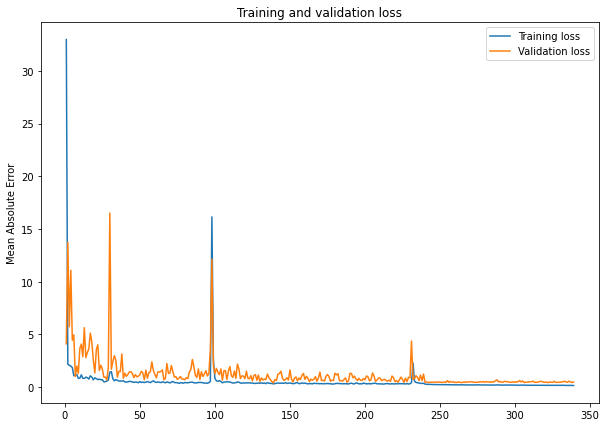

In [76]:
# visualize the loss
loss = nbeats_window_15_horizon_3_history.history['loss']
val_loss = nbeats_window_15_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

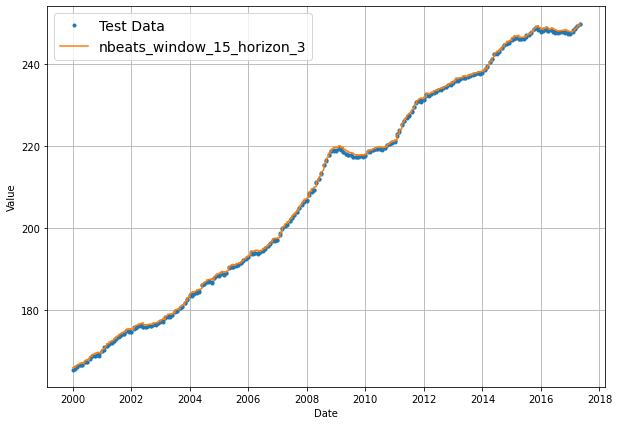

In [77]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(nbeats_window_15_horizon_3_preds, axis=1), format='-', label='nbeats_window_15_horizon_3')

<AxesSubplot:>

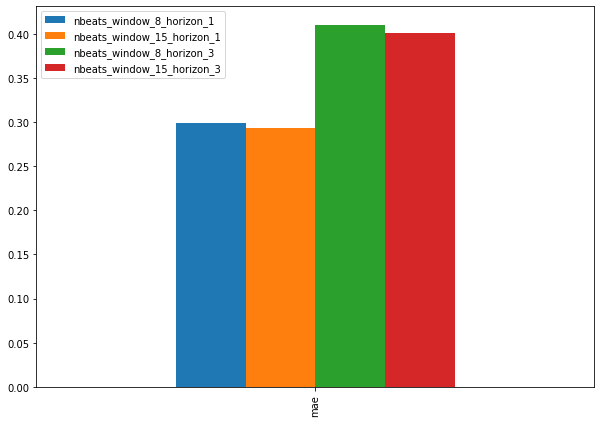

In [88]:
pd.DataFrame({
    'nbeats_window_8_horizon_1':nbeats_window_8_horizon_1_results['mae'],
    'nbeats_window_15_horizon_1': nbeats_window_15_horizon_1_results['mae'],
    'nbeats_window_8_horizon_3': nbeats_window_8_horizon_3_results['mae'],
    'nbeats_window_15_horizon_3': nbeats_window_15_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

# Plots comparing different models with same window and horizon sizes

## Window = 8, Horizon = 1

<AxesSubplot:>

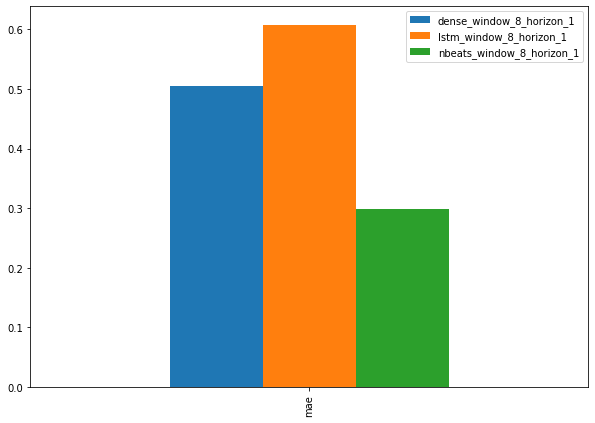

In [147]:
pd.DataFrame({
    'dense_window_8_horizon_1':dense_window_8_horizon_1_results['mae'],
    'lstm_window_8_horizon_1': lstm_window_8_horizon_1_results['mae'],
    'nbeats_window_8_horizon_1': nbeats_window_8_horizon_1_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

## Window = 15, Horizon = 1

<AxesSubplot:>

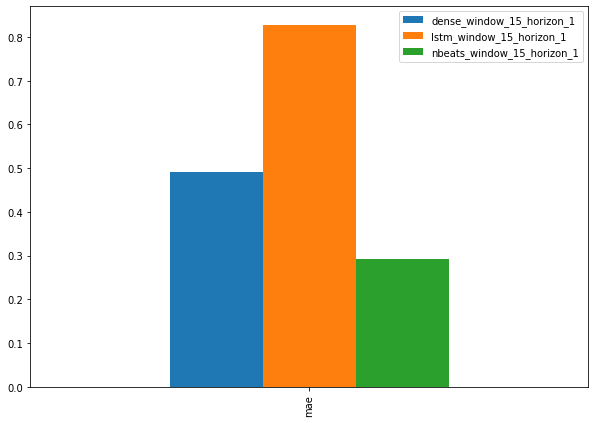

In [148]:
pd.DataFrame({
    'dense_window_15_horizon_1':dense_window_15_horizon_1_results['mae'],
    'lstm_window_15_horizon_1': lstm_window_15_horizon_1_results['mae'],
    'nbeats_window_15_horizon_1': nbeats_window_15_horizon_1_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

## Window = 8, Horizon = 3

<AxesSubplot:>

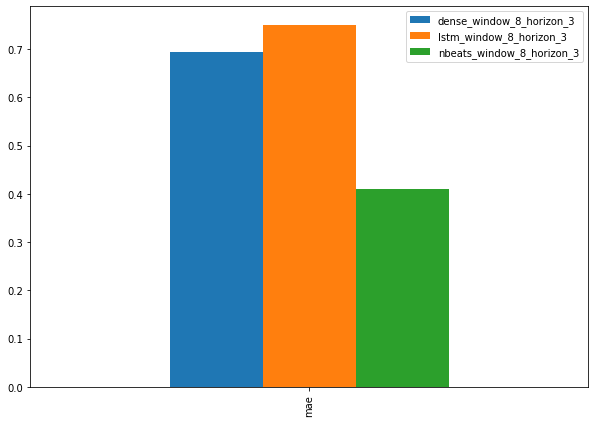

In [149]:
pd.DataFrame({
    'dense_window_8_horizon_3':dense_window_8_horizon_3_results['mae'],
    'lstm_window_8_horizon_3': lstm_window_8_horizon_3_results['mae'],
    'nbeats_window_8_horizon_3': nbeats_window_8_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

## Window = 15, Horizon = 3

<AxesSubplot:>

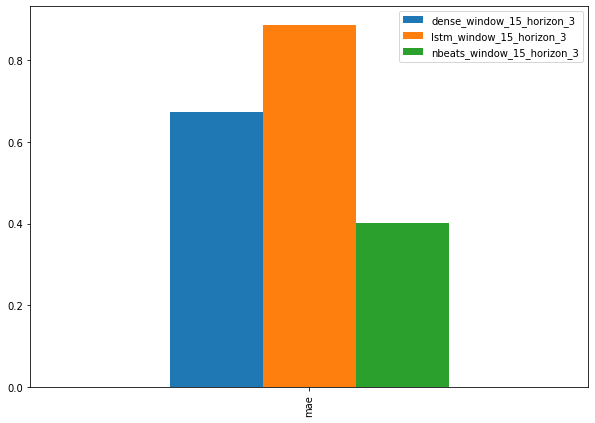

In [150]:
pd.DataFrame({
    'dense_window_15_horizon_3':dense_window_15_horizon_3_results['mae'],
    'lstm_window_15_horizon_3': lstm_window_15_horizon_3_results['mae'],
    'nbeats_window_15_horizon_3': nbeats_window_15_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')